In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
import tensorflow_addons as tfa

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

from tqdm import tqdm

import re
from IPython import display

BATCH_SIZE = 64

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-01-20 00:32:05.140741: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-20 00:32:06.024298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30985 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1c:00.0, compute capability: 7.0


In [4]:
base_path = "/home/michael1017/work/data/comp4/cifar/origin/"

In [5]:
x_train = np.load(base_path + 'x_train_cifar10_unlearn.npy')
# x_train = high_pass_filtered(x_train)
y_train = np.load(base_path + 'y_train_cifar10.npy')
x_val = np.load(base_path + 'x_val_cifar10.npy')
# x_val = high_pass_filtered(x_val)
y_val = np.load(base_path + 'y_val_cifar10.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [6]:
print(x_train.shape)

(40000, 32, 32, 3)


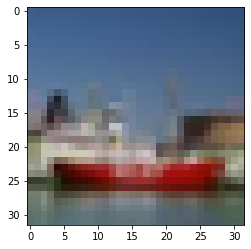

In [7]:
plt.imshow(x_train[0])

In [8]:
tf.random.uniform(shape = (), minval=25, maxval=33, dtype=tf.int32, seed=None, name=None)

<tf.Tensor: shape=(), dtype=int32, numpy=25>

## Data Preprocess

In [9]:
def training_data_generator(x_train, y_train):
    
    #random crop image from 24*24*3 to 32*32*3 and resize it 
    rand_int = tf.random.uniform(shape = (), minval=24, maxval=33, dtype=tf.int32, seed=None, name=None)
    gray_img = tf.image.random_crop(x_train,(rand_int, rand_int,3))
    gray_img = tf.image.resize(gray_img, (32,32))
    
    #random flip left right
    gray_img = tf.image.random_flip_left_right(gray_img)

    gray_img = tf.image.random_contrast(gray_img, lower = 0.2, upper = 1.8)
    gray_img = tf.image.random_hue(gray_img,max_delta=0.5)
    gray_img = tf.image.random_saturation(gray_img, lower = 0.2, upper = 1.8)
    
    #random translate dx dy from -10 ~ 10 (0.2% acc would translate img)
    dx = tf.random.uniform(shape = (), minval=-10, maxval=11, dtype=tf.int32, seed=None, name=None)
    dy = tf.random.uniform(shape = (), minval=-10, maxval=11, dtype=tf.int32, seed=None, name=None)
    if(tf.random.uniform(shape = (), minval=0, maxval=1, dtype=tf.float32) >= 0.8):
        gray_img = tfa.image.translate(images=gray_img,translations=[dx, dy]) 

    return gray_img, y_train

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(training_data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(x_train.shape[0])
batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(x_val.shape[0])
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

2022-01-20 00:32:08.150101: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1657] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


tf.Tensor(7, shape=(), dtype=int64)


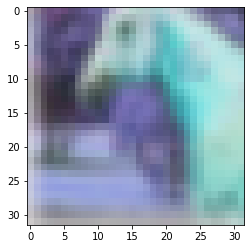

In [11]:
for data in batched_dataset.take(1):
    plt.imshow(data[0][50])
    print(data[1][50])

## Model(vgg16)

In [12]:
model = Sequential(name='vgg16')
model.add(Conv2D(input_shape=(32,32,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(units=1024,activation="relu"))
model.add(Dense(units=1024,activation="relu"))
model.add(Dense(units=10, activation="softmax"))
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       147584    
                                                             

## [Important] you should change your check point direction

In [13]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")
loss_fn = tf.losses.SparseCategoricalCrossentropy()
optimizer = tf.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/michael1017/jinyu/comp4/ckpt2',            ### !!! chage it
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True,
)
callbacks = [
    model_checkpoint_callback,
    tf.keras.callbacks.EarlyStopping(patience=150, monitor = 'val_acc'),
]

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-32GB, compute capability 7.0


In [14]:
history = model.fit(x=batched_dataset, validation_data=batched_val_dataset, callbacks=callbacks, epochs=2000)

Epoch 1/2000


2022-01-20 00:32:14.193679: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7fc70c00bd50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-01-20 00:32:14.193728: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-01-20 00:32:14.209247: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-01-20 00:32:15.033358: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


  9/625 [..............................] - ETA: 8s - loss: 2.3026 - acc: 0.1111    

2022-01-20 00:32:18.797024: I tensorflow/compiler/jit/xla_compilation_cache.cc:351] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - ETA: 0s - loss: 2.1897 - acc: 0.1574

2022-01-20 00:32:29.913866: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/michael1017/jinyu/comp4/ckpt2/assets
625/625 [==============================] - 20s 20ms/step - loss: 2.1897 - acc: 0.1574 - val_loss: 1.9476 - val_acc: 0.2511
Epoch 2/2000
625/625 [==============================] - 14s 19ms/step - loss: 1.9813 - acc: 0.2581 - val_loss: 1.8263 - val_acc: 0.3285
Epoch 3/2000
625/625 [==============================] - 14s 19ms/step - loss: 1.8501 - acc: 0.3114 - val_loss: 1.6198 - val_acc: 0.3987
Epoch 4/2000
625/625 [==============================] - 14s 18ms/step - loss: 1.7110 - acc: 0.3683 - val_loss: 1.4822 - val_acc: 0.4550
Epoch 5/2000
625/625 [==============================] - 14s 19ms/step - loss: 1.5734 - acc: 0.4258 - val_loss: 1.4239 - val_acc: 0.4797
Epoch 6/2000
625/625 [==============================] - 14s 19ms/step - loss: 1.4651 - acc: 0.4665 - val_loss: 1.2972 - val_acc: 0.5326
Epoch 7/2000
625/625 [==============================] - 14s 19ms/step - loss: 1.3658 - acc: 0.5048 - val_loss: 1.2314 -

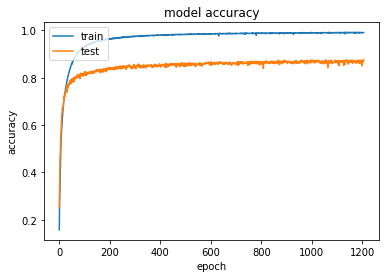

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## infer

## [Important] you should change your check point direction

In [16]:
model = keras.models.load_model('/home/michael1017/jinyu/comp4/ckpt2')

In [17]:
x_test = np.load(base_path + 'x_test_cifar10.npy')

In [18]:
y_pred = model.predict(x_test)

In [19]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape)

(10000,)


In [20]:
print(y_pred[55])

0


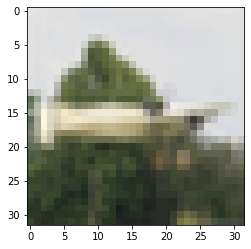

In [21]:
plt.imshow(x_test[55])

In [22]:
pre_df = pd.DataFrame()
for i in range(x_test.shape[0]):
    dic = {'id': int(i), 'label': y_pred[i]}
    pre_df = pre_df.append(dic, ignore_index = True)

In [23]:
print(pre_df.head(10))

    id  label
0  0.0    8.0
1  1.0    8.0
2  2.0    5.0
3  3.0    2.0
4  4.0    6.0
5  5.0    7.0
6  6.0    4.0
7  7.0    0.0
8  8.0    9.0
9  9.0    3.0


## [Important] you should change your output csv direction

In [24]:
pre_df = pre_df.astype(int)
pre_df.to_csv("/home/michael1017/work/data/comp4/cifar/origin/" + "cifar10_pred_202201190504.csv", encoding = 'utf-8',index = False)